In [31]:
# 1. Initialize Spark related
# Please change based on your preferred Spark config - C.J.
import pyspark
from pyspark.sql import SparkSession
from tqdm import tqdm
import matplotlib.pyplot as plt
import statistics

spark = SparkSession.builder.master("local[4]") \
    .appName('PySparkKMeansApp') \
    .getOrCreate()

In [32]:
# 2. Load data
# Create data as RDD, C1/C2 as native lists
def load_all_data(X_path, C1_path, C2_path):
    
    def string_list_to_float(l):
        """
        [['0', '0.64'] ['0.21', '0.28']] to [[0, 0.64], [0.21, 0.28]]
        l: ['0', '0.64']
        """
        return list(map(lambda w: float(w), l))
    
    # X
    X_df = spark.read.text(X_path)
    X_rdd = X_df.rdd.map(lambda l: l[0])  # This will take the first value of each rowData, in our case, the string line
    X_rdd = X_rdd.map(lambda l: l.split(' '))
    X_rdd = X_rdd.map(lambda l: string_list_to_float(l))
    
    # C1 and C2
    def load_data(path):
        with open(path, 'r') as f:
            line = f.readline()
            data = []
            while line:
                tmp_list = line.split(' ')
                # len(tmp_list) should be M
                for i in range(len(tmp_list)):
                    tmp_list[i] = float(tmp_list[i])
                data.append(tmp_list)
                line = f.readline()
        return data
    C1 = load_data(C1_path)
    C2 = load_data(C2_path)
    
    return X_rdd, C1, C2

    

In [33]:
class KMeansSpark():
    def __init__(self, k=10, max_iter=20, dist_policy="Euclidean"):
        self.k = k # num of cluster
        self.max_iter = max_iter # max iteration
        self.dist_policy = dist_policy
        
    def fit(self, X_rdd, C):
        X_rdd = X_rdd.cache() # C.J. This rdd would be used in each iteration. Should we specifically let Spark cache it?
        
        # Calculate initial cost and compute centroid (i.e., the 0th iteration)
        new_C, init_cost = self._run_one_iteration(X_rdd, C)
        cost_per_iter = [init_cost]

        for i in tqdm(range(self.max_iter)):
            new_C, tmp_cost= self._run_one_iteration(X_rdd, new_C)
            cost_per_iter.append(tmp_cost)
        
        return cost_per_iter
    
    def _run_one_iteration(self, X_rdd, C):
        
        # Calculate cost
        X_ext_rdd = X_rdd.map(lambda x : self._partition_and_calc_cost(x, C))
        cost = X_ext_rdd.map(lambda x: x[2]).sum()
            
        # Group points by partition index (partition index, list of points)
        Partition_rdd = X_ext_rdd.map(lambda x: (x[1], x[0])).groupByKey().mapValues(list)

        # For each partition, calculate new centroid
        Centroid_rdd = Partition_rdd.mapValues(lambda p: self._recalc_centroid(p)).map(lambda x: x[1])   
        return Centroid_rdd.collect(), cost
    
    def _partition_and_calc_cost(self, point, C):
        """
        Given each line of X rdd (i.e., each point) and all centriods, find the best partition and calculate min cost
        rdd: [0.0, 0.64, 0.64, 0.0,...]
        ret: ([0.0, 0.64, 0.64, 0.0,...], best_parition_idx, min_cost)
        """
        part_idx = -1
        min_dist = float('inf')
        for p in range(len(C)):
            tmp_dist = self._dist_func(point, C[p])
            if tmp_dist < min_dist:
                part_idx = p
                min_dist = tmp_dist

        return (point, part_idx, min_dist)

    def _recalc_centroid(self, all_points):
        """
        Given all points of one partition, calculate new centroid
        all_points: a list of points [ [x11, x12 ... x158], ...]
        ret: [C1, C2, ... C58]
        """
        num_point = len(all_points)
        num_dimension = len(all_points[0])

        if self.dist_policy == "Euclidean":
            sum_list = [0.0 for i in range(num_dimension)]
            for i in range(num_point):
                for j in range(num_dimension):
                    sum_list[j] += all_points[i][j]

            return [x / num_point for x in sum_list]
        
        elif self.dist_policy == "Manhattan":
            medium_list = [0.0 for i in range(num_dimension)]
            for j in range(num_dimension):
                tmp_list = []
                for i in range(num_point):
                    tmp_list.append(all_points[i][j])
                medium_list[j] = statistics.median(tmp_list)
            return medium_list
        else:
            raise ValueError("Distance policy not found!")
            
    def _dist_func(self, x, c):
        """
        How should we calculate distance of two points?
        
        """
        
        if self.dist_policy == "Euclidean":
            tmp_dist = 0.0
            for i in range(len(x)):
                tmp_dist += (x[i]-c[i])**2   
            return tmp_dist
        elif self.dist_policy == "Manhattan":
            tmp_dist = 0.0
            for i in range(len(x)):
                tmp_dist += abs(x[i]-c[i])   
            return tmp_dist
        else:
            raise ValueError("Distance policy not found!")
            

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.13it/s]


Decrease percentage for C1 is: 25.95%
Decrease percentage for C2 is: 62.14%


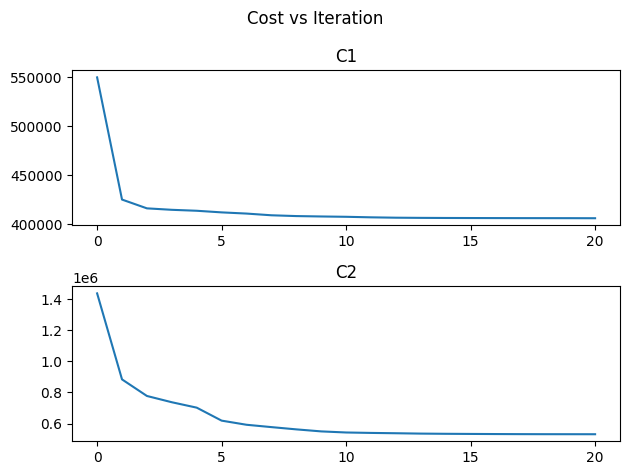

In [34]:
# This is the main driver..
def driver_run(dist_policy, plot_name):
    X_rdd, C1, C2 = load_all_data("../hw2-bundle/kmeans/data/data.txt", "../hw2-bundle/kmeans/data/c1.txt", "../hw2-bundle/kmeans/data/c2.txt")

    KMeans_C1 = KMeansSpark(max_iter=20, dist_policy=dist_policy)
    cost_vs_iter_C1 = KMeans_C1.fit(X_rdd, C1)

    KMeans_C2 = KMeansSpark(max_iter=20, dist_policy=dist_policy)
    cost_vs_iter_C2 = KMeans_C2.fit(X_rdd, C2)

    # Decrease percentage
    print("Decrease percentage for C1 is: {:.2f}%".format((abs(cost_vs_iter_C1[10] - cost_vs_iter_C1[0]) / cost_vs_iter_C1[0]) * 100.0))
    print("Decrease percentage for C2 is: {:.2f}%".format((abs(cost_vs_iter_C2[10] - cost_vs_iter_C2[0]) / cost_vs_iter_C2[0]) * 100.0))
    
    # Plot
    fig, axs = plt.subplots(2)
    fig.suptitle('Cost vs Iteration')

    plt.setp(axs, xticks=[0, 5, 10, 15, 20], xticklabels=['0', '5', '10', '15', '20'])

    idx = [i for i in range(len(cost_vs_iter_C1))]
    axs[0].plot(idx, cost_vs_iter_C1)
    axs[0].set_title('C1')
    axs[1].plot(idx, cost_vs_iter_C2)
    axs[1].set_title('C2')

    fig.tight_layout()
    plt.savefig(plot_name)
    
#driver_run("Euclidean", "a_Euclidean distance.png")
driver_run("Manhattan", "b_Manhattan distance.png")
